In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns #For heatmap
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing
from preprocessing.preprocess_data import DataSet, ReLU, pred_to_delivery, get_constant_indices
from autogluon.tabular import TabularDataset, TabularPredictor

%matplotlib inline

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)



In [4]:
selected_features = ['date_forecast', 'absolute_humidity_2m:gm3',
       'air_density_2m:kgm3', 'clear_sky_energy_1h:J',
       'clear_sky_rad:W', 'dew_or_rime:idx',
       'dew_point_2m:K', 'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W',
       'direct_rad_1h:J', 'effective_cloud_cover:p', 'elevation:m',
       'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm',
       'fresh_snow_3h:cm', 'fresh_snow_6h:cm', 'is_day:idx',
       'is_in_shadow:idx', 'msl_pressure:hPa', 'precip_5min:mm',
       'precip_type_5min:idx', 'pressure_100m:hPa', 'pressure_50m:hPa',
       'prob_rime:p', 'rain_water:kgm2', 'relative_humidity_1000hPa:p',
       'sfc_pressure:hPa', 'snow_depth:cm',
       'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2',
       'sun_azimuth:d', 'sun_elevation:d', 'super_cooled_liquid_water:kgm2',
       't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m',
       'wind_speed_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms',
       'wind_speed_w_1000hPa:ms']


made_features = ['location', 'type', 'is_day:idx', 'is_in_shadow:idx']

drop_feature = 'diffuse_rad:W'

In [5]:
data_collection = DataSet()
data_collection.select_features(selected_features)
data_collection.resample_to_hourly()
data_collection.remove_nans(drop_feature)
# data_collection.drop_bad_data()
data_collection.add_location()
data_collection.add_type()
#
data_collection.combine_obs_est()
data_collection.cyclic_time_encoding()

In [6]:
X_a = data_collection.X_train['a']
X_b = data_collection.X_train['b']
X_c = data_collection.X_train['c']

y_a = data_collection.Y_train['a']
y_b = data_collection.Y_train['b']
y_c = data_collection.Y_train['c']

X = pd.concat([X_a, X_b, X_c])
y = pd.concat([y_a, y_b, y_c])


X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)


In [7]:


constant_y_indices = get_constant_indices(y)

y = y.drop(constant_y_indices, errors='ignore')
X = X.drop(constant_y_indices, errors='ignore')

In [8]:
total_train = X_total = pd.concat([X, y], axis=1)

# drop_cols = ['building', 'date_forecast', 'date_calc', 'ceiling_height_agl:m', 'cloud_base_agl:m', 'snow_density:kgm3']
drop_cols = ['location', 'time']

df_a = total_train[total_train['location'] == 'a'].drop(columns=drop_cols)
df_b = total_train[total_train['location'] == 'b'].drop(columns=drop_cols)
df_c = total_train[total_train['location'] == 'c'].drop(columns=drop_cols)



In [9]:
seed = 246

data = dict()

# sample 50% of the data for each building with type = 0
df_a_tune = df_a[df_a['type'] == 0].sample(frac=0.5, random_state=seed)
df_b_tune = df_b[df_b['type'] == 0].sample(frac=0.5, random_state=seed)   
df_c_tune = df_c[df_c['type'] == 0].sample(frac=0.5, random_state=seed)

# drop these rows from the original data
df_a_train = df_a.drop(df_a_tune.index)
df_b_train = df_b.drop(df_b_tune.index)
df_c_train = df_c.drop(df_c_tune.index)

data['a'] = [df_a_train, df_a_tune]
data['b'] = [df_b_train, df_b_tune]
data['c'] = [df_c_train, df_c_tune]

# Model

In [88]:
label = 'pv_measurement'
predictor_a = TabularPredictor(label=label, eval_metric='mae').fit(
    train_data = data['a'][0], 
    time_limit = 6,
    presets='best_quality',
    num_bag_folds=8,
    num_stack_levels=0,
    tuning_data = data['a'][1],
    use_bag_holdout=True
)

No path specified. Models will be saved in: "AutogluonModels/ag-20231106_150853/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 6s
AutoGluon will save models to "AutogluonModels/ag-20231106_150853/"
AutoGluon Version:  0.8.2
Python Version:     3.10.7
Operating System:   Darwin
Platform Machine:   x86_64
Platform Version:   Darwin Kernel Version 19.6.0: Thu Jan 13 01:26:33 PST 2022; root:xnu-6153.141.51~3/RELEASE_X86_64
Disk Space Avail:   277.83 GB / 500.07 GB (55.6%)
Train Data Rows:    31864
Train Data Columns: 47
Tuning Data Rows:    2197
Tuning Data Columns: 47
Label Column: pv_measurement
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (5733.42, 0.0, 650.65332, 1179.83452)
	If 'regression' is not the corre

Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2775.53 MB
	Train Data (Original)  Memory Usage: 7.08 MB (0.3% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 1 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Useless Original Features (Count: 2): ['elevation:m', 'snow_drift:idx']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be pres

In [89]:
predictor_b = TabularPredictor(label=label, eval_metric='mae').fit(
    train_data = data['b'][0], 
    time_limit = 6,
    presets='best_quality',
    num_bag_folds=8,
    num_stack_levels=0,
    tuning_data = data['b'][1],
    use_bag_holdout=True
)

No path specified. Models will be saved in: "AutogluonModels/ag-20231106_150901/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 6s
AutoGluon will save models to "AutogluonModels/ag-20231106_150901/"
AutoGluon Version:  0.8.2
Python Version:     3.10.7
Operating System:   Darwin
Platform Machine:   x86_64
Platform Version:   Darwin Kernel Version 19.6.0: Thu Jan 13 01:26:33 PST 2022; root:xnu-6153.141.51~3/RELEASE_X86_64
Disk Space Avail:   277.81 GB / 500.07 GB (55.6%)
Train Data Rows:    28069
Train Data Columns: 47
Tuning Data Rows:    1800
Tuning Data Columns: 47
Label Column: pv_measurement
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (1152.3, -0.0, 96.75875, 204.58862)
	If 'regression' is not the correct

In [90]:
predictor_c = TabularPredictor(label=label, eval_metric='mae').fit(
    train_data = data['c'][0], 
    time_limit = 6,
    presets='best_quality',
    num_bag_folds=8,
    num_stack_levels=0,
    tuning_data = data['c'][1],
    use_bag_holdout=True
)

No path specified. Models will be saved in: "AutogluonModels/ag-20231106_150907/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 6s
AutoGluon will save models to "AutogluonModels/ag-20231106_150907/"
AutoGluon Version:  0.8.2
Python Version:     3.10.7
Operating System:   Darwin
Platform Machine:   x86_64
Platform Version:   Darwin Kernel Version 19.6.0: Thu Jan 13 01:26:33 PST 2022; root:xnu-6153.141.51~3/RELEASE_X86_64
Disk Space Avail:   277.80 GB / 500.07 GB (55.6%)
Train Data Rows:    24574
Train Data Columns: 47
Tuning Data Rows:    1465
Tuning Data Columns: 47
Label Column: pv_measurement
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (999.6, 0.0, 79.79638, 168.46701)
	If 'regression' is not the corr

In [91]:
predictor_a.refit_full()
predictor_b.refit_full()
predictor_c.refit_full()

Refitting models via `predictor.refit_full` using all of the data (combined train and validation)...
	Models trained in this way will have the suffix "_FULL" and have NaN validation score.
	This process is not bound by time_limit, but should take less time than the original `predictor.fit` call.
	To learn more, refer to the `.refit_full` method docstring which explains how "_FULL" models differ from normal models.
Fitting 1 L1 models ...
Fitting model: KNeighborsUnif_BAG_L1_FULL ...
	0.07s	 = Training   runtime
Fitting 1 L1 models ...
Fitting model: KNeighborsDist_BAG_L1_FULL ...
	0.05s	 = Training   runtime
Fitting model: WeightedEnsemble_L2_FULL | Skipping fit via cloning parent ...
	0.2s	 = Training   runtime
Updated best model to "WeightedEnsemble_L2_FULL" (Previously "WeightedEnsemble_L2"). AutoGluon will default to using "WeightedEnsemble_L2_FULL" for predict() and predict_proba().
Refit complete, total runtime = 0.32s
Refitting models via `predictor.refit_full` using all of the 

{'KNeighborsUnif_BAG_L1': 'KNeighborsUnif_BAG_L1_FULL',
 'KNeighborsDist_BAG_L1': 'KNeighborsDist_BAG_L1_FULL',
 'WeightedEnsemble_L2': 'WeightedEnsemble_L2_FULL'}

In [92]:
predictor_a.leaderboard(silent=True)

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-169.754903,5.784750,0.355429,0.000773,0.204328,2,True,3
1,KNeighborsDist_BAG_L1,-169.832555,2.941000,0.074435,2.941000,0.074435,1,True,2
2,KNeighborsUnif_BAG_L1,-169.960934,2.842976,0.076666,2.842976,0.076666,1,True,1
3,WeightedEnsemble_L2_FULL,NaN,NaN,0.319820,NaN,0.204328,2,True,6
4,KNeighborsUnif_BAG_L1_FULL,NaN,NaN,0.065594,NaN,0.065594,1,True,4
5,KNeighborsDist_BAG_L1_FULL,NaN,NaN,0.049898,NaN,0.049898,1,True,5


In [93]:
predictor_b.leaderboard(silent=True)

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-26.022127,5.155992,0.318294,0.000735,0.194923,2,True,3
1,KNeighborsUnif_BAG_L1,-26.055571,2.663543,0.054733,2.663543,0.054733,1,True,1
2,KNeighborsDist_BAG_L1,-26.106373,2.491714,0.068638,2.491714,0.068638,1,True,2
3,WeightedEnsemble_L2_FULL,NaN,NaN,0.276204,NaN,0.194923,2,True,6
4,KNeighborsUnif_BAG_L1_FULL,NaN,NaN,0.042793,NaN,0.042793,1,True,4
5,KNeighborsDist_BAG_L1_FULL,NaN,NaN,0.038488,NaN,0.038488,1,True,5


In [94]:
predictor_c.leaderboard(silent=True)


,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,KNeighborsDist_BAG_L1,-20.790667,1.902338,0.063929,1.902338,0.063929,1,True,2
1,WeightedEnsemble_L2,-20.790667,1.903084,0.240137,0.000746,0.176208,2,True,3
2,KNeighborsUnif_BAG_L1,-20.884369,1.867130,0.051149,1.867130,0.051149,1,True,1
3,WeightedEnsemble_L2_FULL,NaN,NaN,0.212908,NaN,0.176208,2,True,6
4,KNeighborsUnif_BAG_L1_FULL,NaN,NaN,0.036071,NaN,0.036071,1,True,4
5,KNeighborsDist_BAG_L1_FULL,NaN,NaN,0.036700,NaN,0.036700,1,True,5


# Predictions

In [101]:
test_a = data_collection.X_test_estimated['a'].drop(columns=['location', 'date_forecast'])
test_b = data_collection.X_test_estimated['b'].drop(columns=['location', 'date_forecast'])
test_c = data_collection.X_test_estimated['c'].drop(columns=['location', 'date_forecast'])


,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,type,sin_hour,sin_month,cos_hour,cos_month
0,4.325,1.28675,0.000000,0.000000,0.0,271.650024,0.000000,0.000000,0.000000,0.000000,74.949997,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1013.674988,0.0,0.0,1000.549988,1006.799988,0.0,0.0,80.275002,1013.099976,0.0,0.0,0.0,0.0,16.026501,-10.54100,0.000,273.799988,74.949997,29907.500000,3.950,2.100,3.350,0.0,0,0.000000,0.5,1.000000,-0.866025
1,4.275,1.28600,0.000000,0.000000,0.0,271.450012,0.000000,0.000000,0.000000,0.000000,77.474998,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1013.150024,0.0,0.0,1000.049988,1006.299988,0.0,0.0,79.824997,1012.599976,0.0,0.0,0.0,0.0,30.497250,-7.89450,0.000,273.799988,77.474998,29519.074219,3.825,1.925,3.300,0.0,0,0.258819,0.5,0.965926,-0.866025
2,4.150,1.28375,0.000000,0.000000,0.0,271.049988,0.000000,0.000000,0.000000,0.000000,88.099998,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1012.674988,0.0,0.0,999.500000,1005.799988,0.0,0.0,78.000000,1012.049988,0.0,0.0,0.0,0.0,44.517250,-3.81550,0.000,273.849976,88.099998,31009.125000,3.650,1.750,3.200,0.0,0,0.500000,0.5,0.866025,-0.866025
3,4.025,1.28200,10124.424805,11.675000,0.0,270.649994,9.375000,16845.226562,2.100000,3765.350098,68.599998,6.0,0.0,0.0,0.0,0.0,0.0,0.75,0.5,1012.174988,0.0,0.0,998.974976,1005.224976,0.0,0.0,75.625000,1011.525024,0.0,0.0,0.0,0.0,58.083000,1.41250,0.000,273.899994,68.599998,34552.500000,3.500,1.450,3.150,0.0,0,0.707107,0.5,0.707107,-0.866025
4,3.900,1.28100,141748.593750,76.875000,0.0,270.375000,47.400002,102209.703125,25.450001,49571.199219,66.300003,6.0,0.0,0.0,0.0,0.0,0.0,1.00,0.0,1011.724976,0.0,0.0,998.549988,1004.750000,0.0,0.0,74.224998,1011.049988,0.0,0.0,0.0,0.0,71.341003,7.46850,0.000,273.924988,66.300003,35483.875000,3.325,1.300,3.050,0.0,0,0.866025,0.5,0.500000,-0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531,8.350,1.19725,477093.187500,85.099998,0.0,281.575012,33.625000,168774.546875,13.425000,50963.250000,85.574997,6.0,0.0,0.0,0.0,0.0,0.0,1.00,0.0,992.099976,0.0,0.0,979.599976,985.424988,0.0,0.0,69.324997,991.325012,0.0,0.0,0.0,0.0,306.687012,8.15300,0.100,287.024994,86.150002,44056.375000,2.450,2.075,-1.350,0.0,0,-0.965926,-0.5,0.258819,-0.866025
1532,8.525,1.20050,184335.671875,24.799999,0.0,281.850006,14.325000,86321.125000,3.550000,30565.875000,74.599998,6.0,0.0,0.0,0.0,0.0,0.0,1.00,0.0,992.549988,0.0,0.0,980.025024,985.900024,0.0,0.0,72.900002,991.799988,0.0,0.0,0.0,0.0,319.704010,3.26800,0.000,286.600006,75.324997,44017.175781,2.450,2.100,-1.250,0.0,0,-0.866025,-0.5,0.500000,-0.866025
1533,8.825,1.20450,37429.328125,1.275000,0.0,282.325012,1.300000,28169.150391,0.000000,6409.899902,76.125000,6.0,0.0,0.0,0.0,0.0,0.0,0.25,1.0,992.900024,0.0,0.0,980.349976,986.250000,0.0,0.0,78.050003,992.150024,0.0,0.0,0.0,0.0,333.040009,-0.44325,0.000,286.100006,76.849998,43302.050781,2.575,2.150,-1.400,0.0,0,-0.707107,-0.5,0.707107,-0.866025
1534,9.025,1.20700,360.049988,0.000000,0.0,282.675018,0.000000,2350.725098,0.000000,0.000000,98.224998,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,993.224976,0.0,0.0,980.700012,986.599976,0.0,0.0,81.750000,992.525024,0.0,0.0,0.0,0.0,346.686005,-2.75050,0.075,285.549988,98.324997,40505.851562,2.250

In [102]:
y_pred_a = predictor_a.predict(test_a)
y_pred_b = predictor_b.predict(test_b)
y_pred_c = predictor_c.predict(test_c)

In [103]:
final_pred = pd.concat([y_pred_a, y_pred_b, y_pred_c]).reset_index(drop=True)
final_pred = ReLU(final_pred)
# print mean of final predictions
print('mean of final pred: ', final_pred.mean())

mean of final pred:  592.7146


In [106]:
cb_sub = pd.read_csv('Delivered_preds/cb_6.csv')
cb_sub

,id,prediction
0,0,0.001420
1,1,0.001196
2,2,0.011456
3,3,48.697305
4,4,319.312725
...,...,...
2155,2155,42.586763
2156,2156,15.344408
2157,2157,0.090076
2158,2158,1.289100


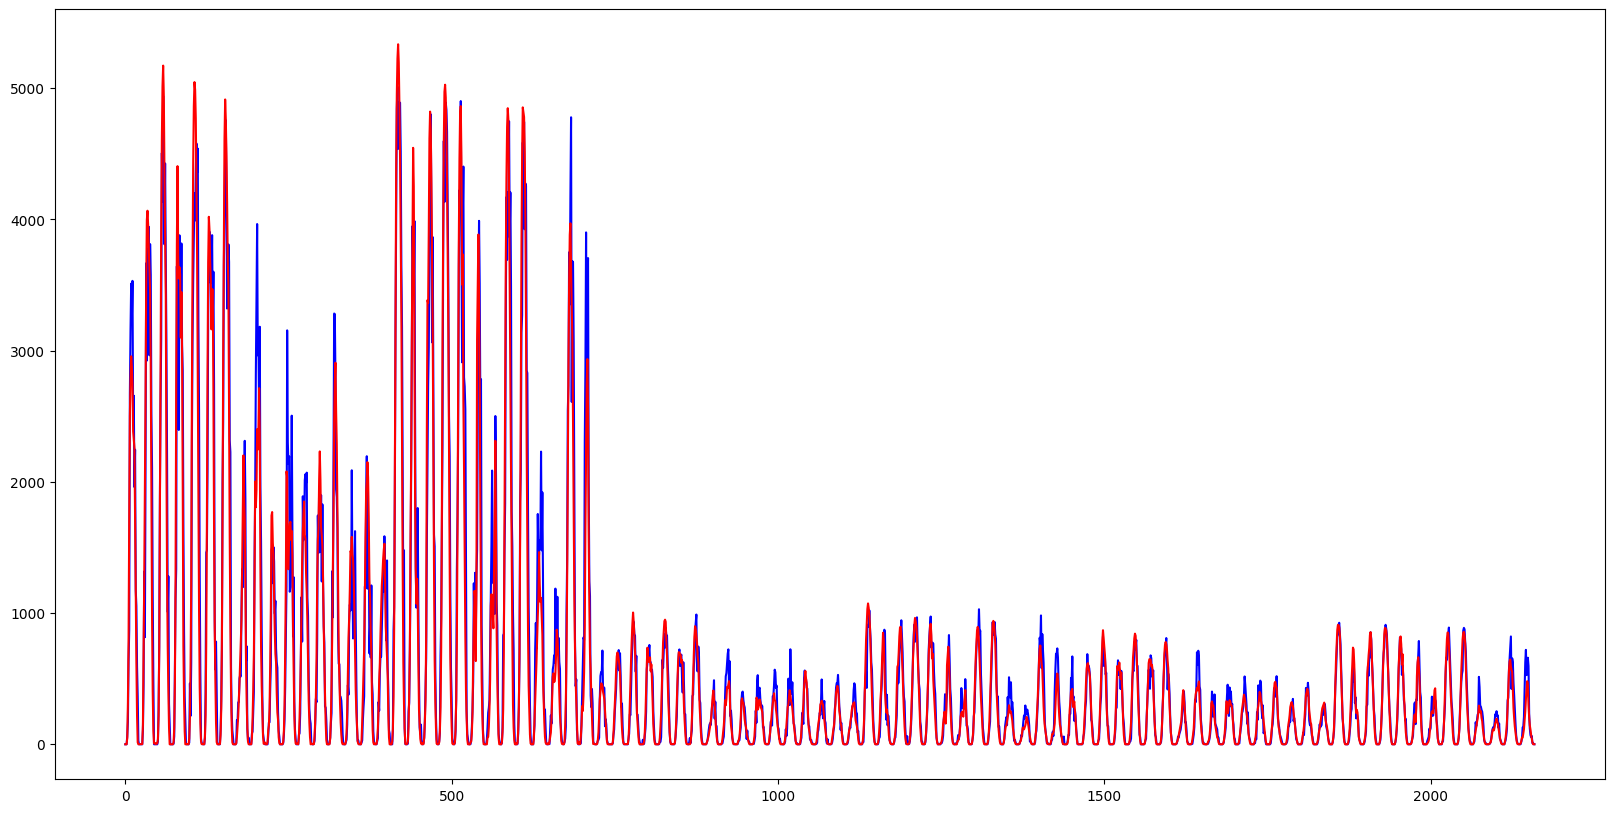

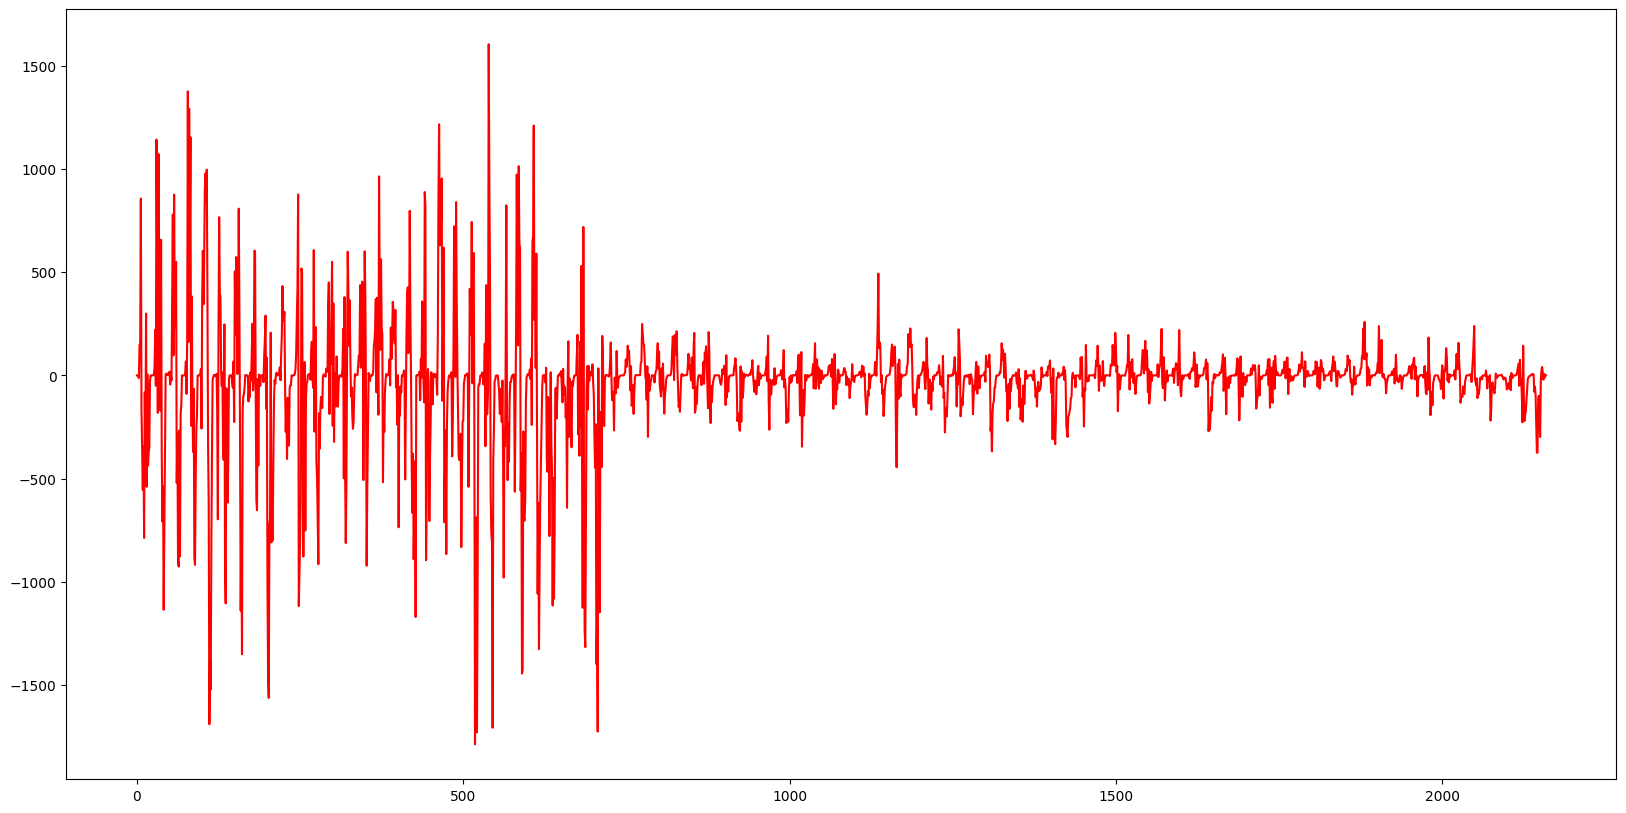

In [115]:
cb_sub = pd.read_csv('Delivered_preds/cb_6.csv')

plt.figure(figsize=(20, 10))
plt.plot(final_pred, color = 'blue')
plt.plot(cb_sub["prediction"], color = 'red')
plt.show()
plt.figure(figsize=(20, 10))
plt.plot(cb_sub["prediction"] - final_pred, color = 'red')
plt.show()

In [114]:
mean_absolute_error(cb_sub["prediction"], final_pred)

131.17000102146022

In [ ]:
if save:
    pred_to_delivery(ReLU(final_pred),'Delivered_preds/' + model_name + '.csv')